In [63]:
import nltk, re, pprint
from nltk import word_tokenize
import os,json
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize 
import nltk.data
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import sentiment
from nltk import word_tokenize
import augur
import sqlalchemy as s
import matplotlib
import pandas as pd
%matplotlib inline
#nltk.download('punkt')
#nltk.download('stopwords')
#pip install twython
#nltk.download('vader_lexicon')

In [27]:
if("notebooks" not in os.getcwd()):
    os.chdir("notebooks")
augurApp = augur.Application('../augur.config.json')
connect = augurApp.ghtorrentplus()

In [28]:
table_names = s.inspect(connect.db).get_table_names()
print(table_names)

['issue_response_time', 'mail_lists', 'mail_lists_sentiment_scores', 'mailing_list_jobs']


In [29]:
if("mailing_list_jobs" in table_names):
    lists_createdSQL = s.sql.text("""SELECT project FROM mailing_list_jobs""")
    df1 = pd.read_sql(lists_createdSQL, connect.db)
    print(df1)
    val = True

          project
0      aalldp-dev
1  archetypes-dev


In [30]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
sid = SentimentIntensityAnalyzer()
col = 'score','sentiment'
columns1 = 'augurmsgID', 'backend_name','project','mailing_list','category',\
           'message_part','message_parts_tot', 'subject','date',\
           'message_from','message_id','message_text'
df3 = pd.DataFrame(columns = col)
df_list = pd.DataFrame(columns = columns1)
for i in df1['project'].values:
    print(i,"Mailing List")
    SQL = s.sql.text("""SELECT * 
    FROM mail_lists WHERE mailing_list = """ +  "'" + i + "'")
    df2 = pd.read_sql(SQL, connect.db)
    df_list = df_list.append(df2)
    #print(df2)
    grouped = df2.groupby('message_id').groups
    print("Here!!!!")
    #print("\n\n","-"*70,"\n\n")
    for group in grouped:
        parts = 0
        numb = len(df2.loc[df2['message_id'] == group]['message_parts_tot'].tolist())
        message = (df2.loc[df2['message_id'] == group]['message_text']).tolist()
        message_text = ''.join(message)
        sentences = tokenizer.tokenize(message_text)
        compound = parts = 0
        sentiment = "Positive"
        for sentence in sentences:
            scores = sid.polarity_scores(sentence)
            compound+= scores['compound']
            parts+=1
        avg_score = compound/parts
        if(avg_score == 0):
            sentiment = "Neutral"
        elif(avg_score < 0):
            sentiment = "Negative"
        #print(message)
        for i in range(numb):
            li = [ [avg_score, sentiment] ]
            df_temp = pd.DataFrame(li,columns = col)
            #print(df_temp['score'])
            df3 = df3.append(df_temp)
            #print(df3)
    print("\n\n")

aalldp-dev Mailing List
Here!!!!



archetypes-dev Mailing List
Here!!!!





In [31]:
print(df3)
print(df_list)
df3 = df3.reset_index(drop=True)
df_list = df_list.reset_index(drop=True)
combine = (df_list.join(df3))

      score sentiment
0  0.140263  Positive
0  0.140263  Positive
0  0.624650  Positive
0  0.624650  Positive
0  0.148000  Positive
0  0.148000  Positive
0  0.285950  Positive
0  0.285950  Positive
  augurmsgID backend_name                                            project  \
0          1    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
1          2    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
2          3    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
3          4    Pipermail  https://lists.opendaylight.org/pipermail/aalld...   
0          5    Pipermail  https://lists.opendaylight.org/pipermail/arche...   
1          6    Pipermail  https://lists.opendaylight.org/pipermail/arche...   
2          7    Pipermail  https://lists.opendaylight.org/pipermail/arche...   
3          8    Pipermail  https://lists.opendaylight.org/pipermail/arche...   

     mailing_list category message_part message_parts_tot  \
0      aalldp-dev  m

In [32]:
print(list(combine))

['augurmsgID', 'backend_name', 'project', 'mailing_list', 'category', 'message_part', 'message_parts_tot', 'subject', 'date', 'message_from', 'message_id', 'message_text', 'score', 'sentiment']


In [33]:
combine.to_sql(name='mail_lists_sentiment_scores',con=connect.db,if_exists='replace',index=False)

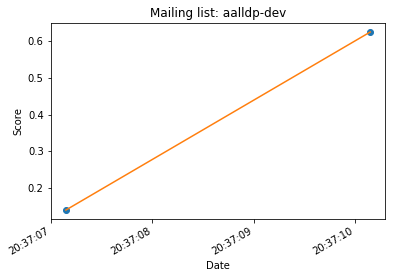

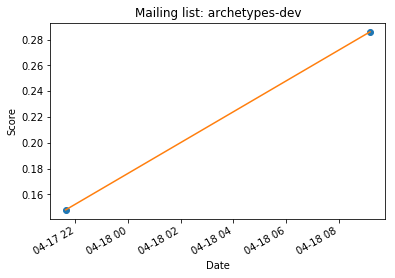

In [75]:
grouped = combine.groupby('mailing_list').groups
dates = []
values = []
mail_list = None
for group in grouped:
    dates = (combine.loc[combine['mailing_list'] == group]['date']).tolist()
    values = (combine.loc[combine['mailing_list'] == group]['score']).unique().tolist()
    x = np.array(dates)
    dates = np.unique(x)
    #print(np.unique(dates),"Here")
    #print((combine.loc[combine['mailing_list'] == group]['date']).tolist())
    #print((combine.loc[combine['mailing_list'] == group]['score']).unique().tolist())
    matplotlib.pyplot.plot_date(dates, values)
    matplotlib.pyplot.plot(dates,values)
    # beautify the x-labels
    matplotlib.pyplot.gcf().autofmt_xdate()
    matplotlib.pyplot.title("Mailing list: " + group)
    matplotlib.pyplot.ylabel('Score')
    matplotlib.pyplot.xlabel('Date')
    matplotlib.pyplot.show()